In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
# read 7-year-old data
data_path = './ncds_sweep0-3/tab/ncds0123.tab'
data = pd.read_csv(data_path, delimiter='\t').set_index('ncdsid')

# separate predictor and response
y_df = data['n1842'].copy()
x_df = data.drop('n1842', axis = 1)

# set y_df to binary: 5 or others
mask_1 = y_df == '5'
y_df[mask_1] = 1
y_df[~mask_1] = 0

/Users/hung-yiwu/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,3,4,5,1756,1757,1758,1759,1760,1761,1762,1763,1764) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# n415: 1M Epileptic condition
# 2: no
# 1, -1: defect data
# obtained at 1965, 7y

# n2032: 3M Epilepsy
# 1: no
# -1: defect data
# obtained at 1974, 16y

# focus on those not epileptic at 1965 but epileptic at 1969

In [4]:
mask_1M_no = data['n415'] == '2'

mask_3M_no = data['n2032'] == '1'
mask_3M_defect = data['n2032'] == '-1'
mask_3M_yes = ~(mask_3M_no | mask_3M_defect)

mask_1M_no_3M_yes = mask_1M_no & mask_3M_yes

print '{} people have no epilepsy at 1965 (7-year-old)'.format(sum(mask_1M_no))
print '{} people have epilepsy at 1974 (16-year-old)'.format(sum(mask_3M_yes))
print '{} people have no epilepsy at 7-year-old but have epilepsy at 16-year-old'.format(\
    sum(mask_1M_no_3M_yes))
print '\nTheir id number:'
print data.index[mask_1M_no_3M_yes].values

13901 people have no epilepsy at 1965 (7-year-old)
4089 people have epilepsy at 1974 (16-year-old)
2002 people have no epilepsy at 7-year-old but have epilepsy at 16-year-old

Their id number:
['N10006T' 'N10009W' 'N10018X' ..., 'N28527C' 'N28540Z' 'N28557J']


In [5]:
# predictor variables are those in 1, 2, 3 but no keyword 'epilep' in manual
# response variable is 'acquired epilepsy', all mask_1M_no, those in mask_3M_yes are 1, else 0

In [6]:
doi = data[mask_1M_no]
y_df = pd.Series( np.zeros(data.shape[0]) )
y_df[mask_1M_no_3M_yes.values] = 1
y_df = y_df[mask_1M_no.values]
print 'Epilepsy condition survey:'
print y_df.value_counts()

Epilepsy condition survey:
0.0    11899
1.0     2002
dtype: int64


In [7]:
# file path of explain file
explain_path = '/Users/hung-yiwu/Documents/AC209a_project/data/ncds_sweep0-3/mrdoc/allissue/ncds0123_ukda_data_dictionary.rtf'

# open explain file
explain = open(explain_path, 'r')

# read the whole file as a single giant string
explain_text = explain.read()

# SPSS measurement level target string
target_string_1 = 'the SPSS measurement level is '

# locate SPSS measurement level
target_loc_1 = [m.end() for m in re.finditer(target_string_1, explain_text)]

# variable label target string
target_string_2 = 'Variable label = '

# locate variable label
target_loc_2 = [m.end() for m in re.finditer(target_string_2, explain_text)]

# remove the first one (id)
target_loc_2 = target_loc_2[1:]

# variable code target string
target_string_3 = 'Variable = '

# locate variable code
target_loc_3 = [m.end() for m in re.finditer(target_string_3, explain_text)]

# remove the first one (id)
target_loc_3 = target_loc_3[1:]

In [8]:
var_df = pd.DataFrame({}, columns = ['type', 'label'])

for i in range(len(target_loc_1)):
    # get variable code
    start_pt = target_loc_3[i]+15
    end_pt = explain_text.find('cf1', start_pt)-6
    var_code = explain_text[start_pt:end_pt]
    
    # get variable label
    start_pt = target_loc_2[i]+7
    end_pt = explain_text.find('\par', start_pt)
    var_label = explain_text[start_pt:end_pt]
    
    # get variable type
    char = explain_text[target_loc_1[i] + 9] 
    if char == 'O' or char == 'o' or char == 'N' or char == 'n' \
        or 'region' in var_code:
        var_type = 'categorical'
    else:
        var_type = 'numerical'

    # append to DataFrame
    var_df.loc[var_code] = [var_type, var_label]

In [9]:
print '{} variables'.format(var_df.shape[0])
print 'sample variable list:'
var_df.head()

1764 variables
sample variable list:


,type,label
n622,categorical,0-3D Sex of child
n0region,categorical,Region at PMS (1958) - Birth
n1region,categorical,Region at NCDS1 (1965) - 7 years
n2region,categorical,Region at NCDS2 (1969) - 11 years
n3region,categorical,Region at NCDS3 (1974) - 16 years


In [10]:
variable_of_interest = []
for index, row in var_df.iterrows():
    starting_text = row['label'][0:1]
    if 'epilep' in row['label'] or 'Epilep' in row['label']:
        continue
    if 'convuls' in row['label'] or 'Convuls' in row['label']:
        continue
    if 'Special Education' in row['label']:
        continue
    if 'Region' in row['label']:
        continue
    if 'neuro' in row['label']:
        continue
    if 'Reason' in row['label'] or 'reason' in row['label']:
        continue
    if 'handicap' in row['label']:
        continue
    if 'psychi' in row['label']:
        continue
    if index == 'n1910':
        continue
    if index == 'n1964':
        continue
    if index == 'n2032':
        continue
    if index == 'n2598':
        continue
    if index == 'n2603':
        continue
    if index == 'n2604':
        continue
    if index == 'n2605':
        continue
    if index == 'n2606':
        continue
    if index == 'n2607':
        continue
    if index == 'n2608':
        continue
    if index == 'n2663':
        continue
    if index == 'n622' or starting_text == '2' or starting_text == '3':
        variable_of_interest.append(index)

print '{} predictors in file'.format( var_df.shape[0] )
print '{} predictors of interest'.format( len(variable_of_interest) )

1764 predictors in file
1204 predictors of interest


In [11]:
x_df = doi[variable_of_interest]

In [12]:
# iterate through all variables
# dummify categorical variables
# standardize numeric variables

x_df_extended_list = []

for col in x_df.columns:
    # if this column is categorical
    if var_df.loc[col, 'type'] == 'categorical':
        # copy current column
        curr_df = x_df[col].copy()
        # format all value to string
        curr_df = curr_df.astype(str)
        # set value ' ' to value '-1'
        curr_df[curr_df == ' '] = '-1'
        # if this column contains NaN
        if curr_df.isnull().values.any():
            # get dummy with NaN as a unique value
            dummy = pd.get_dummies(curr_df, dummy_na = True)
        # if this column does not contain NaN
        else:
            # get dummy without considering NaN
            dummy = pd.get_dummies(curr_df, dummy_na = False)
        # reset column label of dummy
        dummy.columns = [str(col)+'='+str(value) for value in dummy.columns]
        # reset index label of dummy
        dummy.index = x_df.index
        # append current dummy DataFrame to master list
        x_df_extended_list.append(dummy)
    # if this column is numerical
    else:
        # copy current column
        curr_df = x_df[col].copy()
        # set value ' ' to value -1
        curr_df[curr_df == ' '] = -1
        # set value NaN to value -1
        curr_df[curr_df.isnull()] = -1
        # convert current column to float
        curr_df = curr_df.astype(float)
        # standardize it
        curr_df = pd.DataFrame(scale(curr_df.values))
        # reset index label of current DataFrame
        curr_df.index = x_df.index
        # append current DataFrame to master list
        x_df_extended_list.append(curr_df)
        
# concatenate master list to get master data
x_df_extended = pd.concat(x_df_extended_list, axis = 1)

print '{} observations'.format(x_df_extended.shape[0])
print '{} variables (after dummy expansion)'.format(x_df_extended.shape[1])

13901 observations
9044 variables (after dummy expansion)


In [13]:
weight_list = [{1:value} for value in 10**np.arange(-1, 5, 1)]
parameters = {'class_weight':weight_list}
gscv = GridSearchCV(LogisticRegressionCV(), parameters, scoring = 'precision_macro')
gscv.fit(x_df_extended.values, y_df.values)
best_lr_model = gscv.best_estimator_

/Users/hung-yiwu/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
best_lr_model = gscv.best_estimator_
kf = KFold(n_splits = 3)
adf = pd.DataFrame({}, columns = ['accuracy_all', 'accuracy_healthy', 'accuracy_epilepsy'])
index = 0

for train_index, test_index in kf.split(x_df_extended.values):
    x_train = x_df_extended.values[train_index, :]
    x_test = x_df_extended.values[test_index, :]
    y_train = y_df.values[train_index]
    y_test = y_df.values[test_index]
    
    best_lr_model.fit(x_train, y_train)
    
    y_predict = best_lr_model.predict(x_test)
    cm = confusion_matrix(y_test, y_predict)
    accuracy_all = best_lr_model.score(x_test, y_test)
    accuracy_epilepsy = float(cm[1,1])/float(cm[1,0]+cm[1,1])
    accuracy_healthy = float(cm[0,0])/float(cm[0,0]+cm[0,1])
    
    adf.loc[index] = [accuracy_all, accuracy_healthy, accuracy_epilepsy]

In [15]:
print 'Best parameter:', gscv.best_params_
print 'Best precision score:', gscv.best_score_
print adf.mean()

Best parameter: {'class_weight': {1: 1}}
Best precision score: 0.99654530061
accuracy_all         0.994820
accuracy_healthy     0.999249
accuracy_epilepsy    0.967033
dtype: float64


In [16]:
# get coefficient
coef = best_lr_model.coef_.flatten()

most_pos_var_index = np.argsort(coef)[-21:][::-1]
most_neg_var_index = np.argsort(coef)[0:3]

print 'most positive variables'
for index in most_pos_var_index:
    print coef[index], x_df_extended.columns[index],
    
    # get variable name
    if '=' in x_df_extended.columns[index]:
        var_name = x_df_extended.columns[index].split('=', 1)[0]
    else:
        var_name = x_df_extended.columns[index]
    
    print var_df['label'].loc[var_name]

most positive variables
0.994764297715 n2038=2 3M Any other abnormal condition
0.870336702764 n2034=2 3M Diabetes
0.808045694457 n2024=2 3M Abnormality of lower limbs
0.789637593722 n2025=2 3M Abnormality of spine-summary
0.784578115812 n2031=2 3M Abnormality of skin
0.776733317386 n2026=2 3M Abnormality of respiratory system
0.768491687273 n2022=2 3M Abnormality head and neck
0.755082227838 n2030=2 3M Haematological abnormality
0.737346930429 n2037=2 3M Speech defect
0.725103141242 n2023=2 3M Abnormality of upper limbs
0.713461753044 n1908=1 3M Hosp outpatient attendance,last yr
0.687062251789 n2029=2 3M Abnormality of heart
0.684134091664 n2027=2 3M Abnormality of alimentary system
0.673417077621 n2020=2 3M Mental retardation
0.652452829513 n2865=3 3I How often plays outdoor games & sport
0.631405885232 n2028=2 3M Abnormality of urogenital system
0.6129722116 n2325=3 3S Mother's interest in chlds education
0.608689562774 n2021=2 3M Emotional,behavioural problem
0.606884821084 n2019=2

In [17]:
doi_epil = x_df_extended[(y_df == 1).values]
doi_healthy = x_df_extended[(y_df == 0).values]

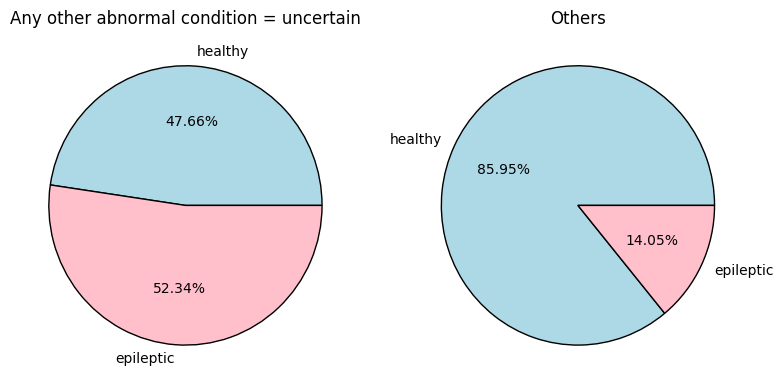

In [18]:
var_name = 'n2038=2' # 3M Any other abnormal condition

mask_positive = (x_df_extended[var_name] == 1).values
positive = y_df[mask_positive].value_counts().sort_index()
negative = y_df[~mask_positive].value_counts().sort_index()
labels = ['healthy', 'epileptic']

fig, axs = plt.subplots(1, 2, figsize = (8,4))

axs[0].pie(positive.values, labels = labels, autopct = '%.2f%%',\
        colors = ['lightblue', 'pink', 'gray'])
axs[0].set_title('Any other abnormal condition = uncertain')

axs[1].pie(negative.values, labels = labels, autopct = '%.2f%%',\
        colors = ['lightblue', 'pink', 'gray'])
axs[1].set_title('Others')

fig.tight_layout()
plt.show()

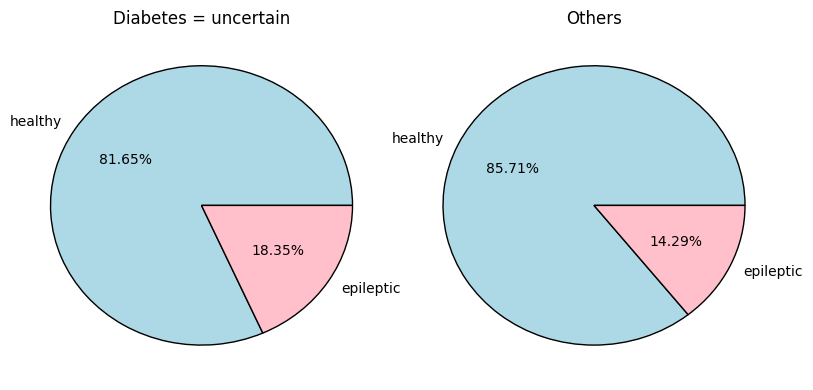

In [19]:
var_name = 'n2034=2' # 3M Diabetes

mask_positive = (x_df_extended[var_name] == 1).values
positive = y_df[mask_positive].value_counts().sort_index()
negative = y_df[~mask_positive].value_counts().sort_index()
labels = ['healthy', 'epileptic']

fig, axs = plt.subplots(1, 2, figsize = (8,4))

axs[0].pie(positive.values, labels = labels, autopct = '%.2f%%',\
        colors = ['lightblue', 'pink', 'gray'])
axs[0].set_title('Diabetes = uncertain')

axs[1].pie(negative.values, labels = labels, autopct = '%.2f%%',\
        colors = ['lightblue', 'pink', 'gray'])
axs[1].set_title('Others')

fig.tight_layout()
plt.show()

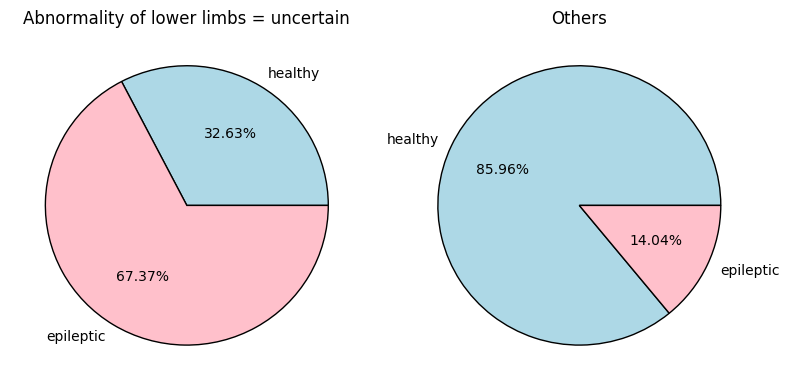

In [20]:
var_name = 'n2024=2' # 3M Diabetes

mask_positive = (x_df_extended[var_name] == 1).values
positive = y_df[mask_positive].value_counts().sort_index()
negative = y_df[~mask_positive].value_counts().sort_index()
labels = ['healthy', 'epileptic']

fig, axs = plt.subplots(1, 2, figsize = (8,4))

axs[0].pie(positive.values, labels = labels, autopct = '%.2f%%',\
        colors = ['lightblue', 'pink', 'gray'])
axs[0].set_title('Abnormality of lower limbs = uncertain')

axs[1].pie(negative.values, labels = labels, autopct = '%.2f%%',\
        colors = ['lightblue', 'pink', 'gray'])
axs[1].set_title('Others')

fig.tight_layout()
plt.show()